In [1]:
!pip install torchinfo

In [2]:
!pip install lightly
!pip install torch-optimizer
!pip install timm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.3/859.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="UnsupportedFieldAttributeWarning")

In [4]:
import os
import time
import copy
import json
import random
import platform
import csv
import psutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import PIL
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

# MAE Imports
from timm.models.vision_transformer import vit_base_patch32_224
from lightly.models.modules import MAEDecoderTIMM, MaskedVisionTransformerTIMM
from lightly.transforms import MAETransform
from lightly.models import utils


This section checks the current Kaggle runtime environment.
It collects and displays:
CPU model using the platform library
Total RAM (in GB) using psutil
GPU name via the nvidia-smi command (if a GPU is available)

In [5]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


To ensure fully deterministic behavior across CPU, CUDA, NumPy, and Python’s built-in RNG, we manually fix all random seeds. This helps in achieving consistent results across multiple runs of training, evaluation, and debugging.

In [6]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

This code organizes PM25Vision images by air-quality labels.
It reads metadata.csv, maps PM2.5 bins to categories (Good, Moderate, Unhealthy, etc.), creates label folders, and copies images accordingly.
Finally, it prints summary counts and skipped files — readying the dataset for training.

In [7]:
import re
import shutil
import pandas as pd
from pathlib import Path


CSV_PATH = Path("/kaggle/input/pm25vision/train/metadata.csv")
IMG_DIR  = Path("/kaggle/input/pm25vision/train/images")
OUT_DIR  = Path("/kaggle/working/dataset")
OUT_DIR.mkdir(parents=True, exist_ok=True)


AQI_BINS = [
    (0, 50, "Good"),
    (51, 100, "Moderate"),
    (101, 150, "Unhealthy_Sensitive"),
    (151, 200, "Unhealthy"),
    (201, 300, "Very_Unhealthy"),
    (301, 10000, "Hazardous"),
]

def aqi_to_label(aqi: int) -> str:
    for lo, hi, label in AQI_BINS:
        if lo <= aqi <= hi:
            return label
    return None  

def bin_to_label(bin_val) -> str:
    """
    Accepts '0–50', '0-50', '0 — 50', etc.
    Extracts the LOWER numeric bound and maps to label.
    """
    s = str(bin_val).strip()
    s = s.replace("–", "-").replace("—", "-").replace("−", "-")
    s = re.sub(r"\s*-\s*", "-", s)
    m = re.search(r"(\d+)", s)
    if not m:
        return None
    lo = int(m.group(1))
    return aqi_to_label(lo)


df = pd.read_csv(CSV_PATH)
assert "pm25_bin" in df.columns, f"Expected 'pm25_bin' column but found {df.columns}"

fname_col = "filename" if "filename" in df.columns else ("file" if "file" in df.columns else None)
if fname_col is None:
    raise ValueError(f"No image filename column found. Columns: {list(df.columns)}")

df["fname"] = df[fname_col].astype(str)
df["level"] = df["pm25_bin"].apply(bin_to_label)


df = df.dropna(subset=["level"])

print("Class counts:")
print(df["level"].value_counts(dropna=False))


for _, _, label in AQI_BINS:
    (OUT_DIR / label).mkdir(parents=True, exist_ok=True)

missing = 0
copied  = 0
valid_labels = {b[2] for b in AQI_BINS}

for _, row in df.iterrows():
    src = IMG_DIR / row["fname"]
    if not src.exists():
        missing += 1
        continue

    if row["level"] not in valid_labels:
        continue

    dst = OUT_DIR / row["level"] / src.name
    shutil.copy2(src, dst)
    copied += 1

print(f"✅ Done! Copied: {copied} | Missing files skipped: {missing}")
print(f"Output root: {OUT_DIR}")


Class counts:
level
Good                   1780
Moderate               1780
Unhealthy_Sensitive    1780
Unhealthy              1780
Very_Unhealthy          822
Hazardous               356
Name: count, dtype: int64
✅ Done! Copied: 8298 | Missing files skipped: 0
Output root: /kaggle/working/dataset


This block organizes the test images into the same labeled structure as the training dataset.
It reads metadata.csv, maps PM2.5 bins to air-quality categories, and copies each image into its respective label folder under /kaggle/working/dataset/.
Duplicate files are checked and renamed if needed, while missing images are skipped.
Finally, it prints a summary of copied, skipped, and renamed files.

In [8]:
TEST_CSV_PATH = Path("/kaggle/input/pm25vision/test/metadata.csv")
TEST_IMG_DIR  = Path("/kaggle/input/pm25vision/test/images")
OUT_DIR       = Path("/kaggle/working/dataset") 


AQI_BINS = [
    (0, 50, "Good"),
    (51, 100, "Moderate"),
    (101, 150, "Unhealthy_Sensitive"),
    (151, 200, "Unhealthy"),
    (201, 300, "Very_Unhealthy"),
    (301, 10000, "Hazardous"),
]

def aqi_to_label(aqi: int) -> str | None:
    for lo, hi, label in AQI_BINS:
        if lo <= aqi <= hi:
            return label
    return None 

def bin_to_label(bin_val) -> str | None:
    s = str(bin_val).strip()
    s = s.replace("–", "-").replace("—", "-").replace("−", "-")
    s = re.sub(r"\s*-\s*", "-", s)
    m = re.search(r"(\d+)", s)
    if not m:
        return None  
    lo = int(m.group(1))
    return aqi_to_label(lo)


df_t = pd.read_csv(TEST_CSV_PATH)
assert "pm25_bin" in df_t.columns, f"Expected 'pm25_bin' in TEST CSV, got: {df_t.columns}"

fname_col_t = "filename" if "filename" in df_t.columns else ("file" if "file" in df_t.columns else None)
if fname_col_t is None:
    raise ValueError(f"No image filename column in TEST CSV. Columns: {list(df_t.columns)}")

df_t["fname"] = df_t[fname_col_t].astype(str)
df_t["level"] = df_t["pm25_bin"].apply(bin_to_label)

missing, copied, skipped_same, renamed_dupe = 0, 0, 0, 0
valid_labels = {b[2] for b in AQI_BINS}

for _, r in df_t.iterrows():
    src = TEST_IMG_DIR / r["fname"]
    if not src.exists():
        missing += 1
        continue

 
    if r["level"] not in valid_labels:
        continue

    dest_dir = OUT_DIR / r["level"]
    dest_dir.mkdir(parents=True, exist_ok=True)

    dst = dest_dir / src.name
    if dst.exists():
     
        if os.path.getsize(dst) == os.path.getsize(src):
            skipped_same += 1
            continue
        dst = dest_dir / f"test__{src.name}"
        renamed_dupe += 1

    shutil.copy2(src, dst)
    copied += 1

print("✅ TEST merge complete.")
print(f"Copied: {copied} | Missing files: {missing} | Skipped exact-duplicates: {skipped_same} | Renamed (name clash): {renamed_dupe}")
print(f"Merged into: {OUT_DIR}")


✅ TEST merge complete.
Copied: 2905 | Missing files: 0 | Skipped exact-duplicates: 16 | Renamed (name clash): 0
Merged into: /kaggle/working/dataset


This code counts the number of images in each air-quality class under /kaggle/working/dataset/.
It prints per-class image totals and the overall dataset size — useful for confirming that all files were organized correctly.

In [9]:
from pathlib import Path
import shutil

OUT_DIR = Path("/kaggle/working/dataset")


unknown_dir = OUT_DIR / "Unknown"
if unknown_dir.exists() and unknown_dir.is_dir():
    shutil.rmtree(unknown_dir)


class_counts = {}
for sub in OUT_DIR.iterdir():
    if sub.is_dir():
        class_counts[sub.name] = len(list(sub.glob("*")))

print(" Image count per class:\n")

for k, v in sorted(class_counts.items()):
    print(f"{k:20s}: {v}")

print("\nTotal images:", sum(class_counts.values()))

 Image count per class:

Good                : 2408
Hazardous           : 481
Moderate            : 2407
Unhealthy           : 2407
Unhealthy_Sensitive : 2393
Very_Unhealthy      : 1007

Total images: 11103


This code scans the organized dataset under /kaggle/working/dataset/ and builds a DataFrame listing each image path and its label.
It filters valid image formats (.jpg, .jpeg, .png), counts total samples per class, and defines a helper function to load images as RGB arrays.
Useful for quick checks, visualization, or later data-loader creation.

In [10]:
from pathlib import Path
from PIL import Image

BASE_DIR = Path("/kaggle/working/dataset")  
assert BASE_DIR.exists(), BASE_DIR

rows = []
for label_dir in sorted([p for p in BASE_DIR.iterdir() if p.is_dir()]):
    label = label_dir.name
    for p in label_dir.glob("*"):
        if p.suffix.lower() not in {".jpg", ".jpeg", ".png"}:
            continue
        rows.append({"path": str(p), "label": label})

df = pd.DataFrame(rows)
print("Total images indexed:", len(df))
print("Class balance:\n", df["label"].value_counts())

def load_rgb(path):
    with Image.open(path) as im:
        im = im.convert("RGB")
        return np.array(im)

df.head(20)

Total images indexed: 11103
Class balance:
 label
Good                   2408
Moderate               2407
Unhealthy              2407
Unhealthy_Sensitive    2393
Very_Unhealthy         1007
Hazardous               481
Name: count, dtype: int64


path label
0    /kaggle/working/dataset/Good/260560528769038.jpg  Good
1    /kaggle/working/dataset/Good/310421104003880.jpg  Good
2   /kaggle/working/dataset/Good/2936259636585652.jpg  Good
3   /kaggle/working/dataset/Good/1170142893428629.jpg  Good
4    /kaggle/working/dataset/Good/751223768896391.jpg  Good
5    /kaggle/working/dataset/Good/314835346681485.jpg  Good
6    /kaggle/working/dataset/Good/169506931738217.jpg  Good
7    /kaggle/working/dataset/Good/251948970761041.jpg  Good
8    /kaggle/working/dataset/Good/598846811509803.jpg  Good
9    /kaggle/working/dataset/Good/883045777281326.jpg  Good
10  /kaggle/working/dataset/Good/3373366536305254.jpg  Good
11  /kaggle/working/dataset/Good/1065693535336057.jpg  Good
12  /kaggle/working/dataset/Good/1164315764034919.jpg  Good
13   /kaggle/working/dataset/Good/137654272271505.jpg  Good
14   /kaggle/working/dataset/Good/806858961639770.jpg  Good
15  /kaggle/working/dataset/Good/2964196587223901.jpg  Good
16  /kaggle/working/dataset/Good/5641775982572506.jpg  Good
17   /kaggle/working/dataset/Good/468947310976758.jpg  Good
18   /kaggle/working/dataset/Good/218583166696656.jpg  Good
19   /kaggle/working/dataset/Good/180696153922333.jpg  Good

This block sets all key file paths for loading the uploaded BYOL checkpoint, saving new checkpoints, tracking loss, and storing embeddings. It also selects the compute device (CPU/GPU) and initializes the main training hyperparameters such as batch size, learning rate, weight decay, and total epochs.

In [11]:
data_dir = "/kaggle/working/dataset"
loss_file = "/kaggle/working/mae_loss.csv"

uploaded_loss_path = "/kaggle/input/loss-curv/loss.csv"
uploaded_resume_path = "/kaggle/input/pretext-resume/mae_checkpoint.pth"

working_checkpoint_path = "/kaggle/working/mae_checkpoint.pth"
embedding_path = "/kaggle/working/mae_embeddings.npz"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

training_batch = 32
learning_rate = 1.5e-4
weight_decay = 0.05
total_epochs = 100


This code visualizes the number of images in each air-quality category using a Seaborn bar chart.
It helps verify dataset balance and ensure all classes are properly represented before training.

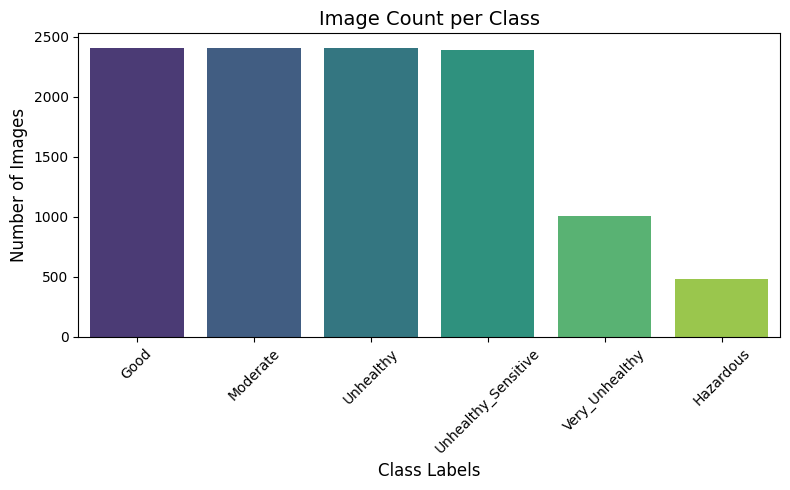

In [12]:
plt.figure(figsize=(8, 5))
sns.barplot(x=df["label"].value_counts().index,
            y=df["label"].value_counts().values,
            palette="viridis")
plt.title("Image Count per Class", fontsize=14)
plt.xlabel("Class Labels", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This code displays a small gallery showing two random sample images from each air-quality class.
It helps visually verify the dataset and observe differences across categories such as Good, Moderate, and Unhealthy.
Useful for quick quality checks and understanding visual variation before model training.

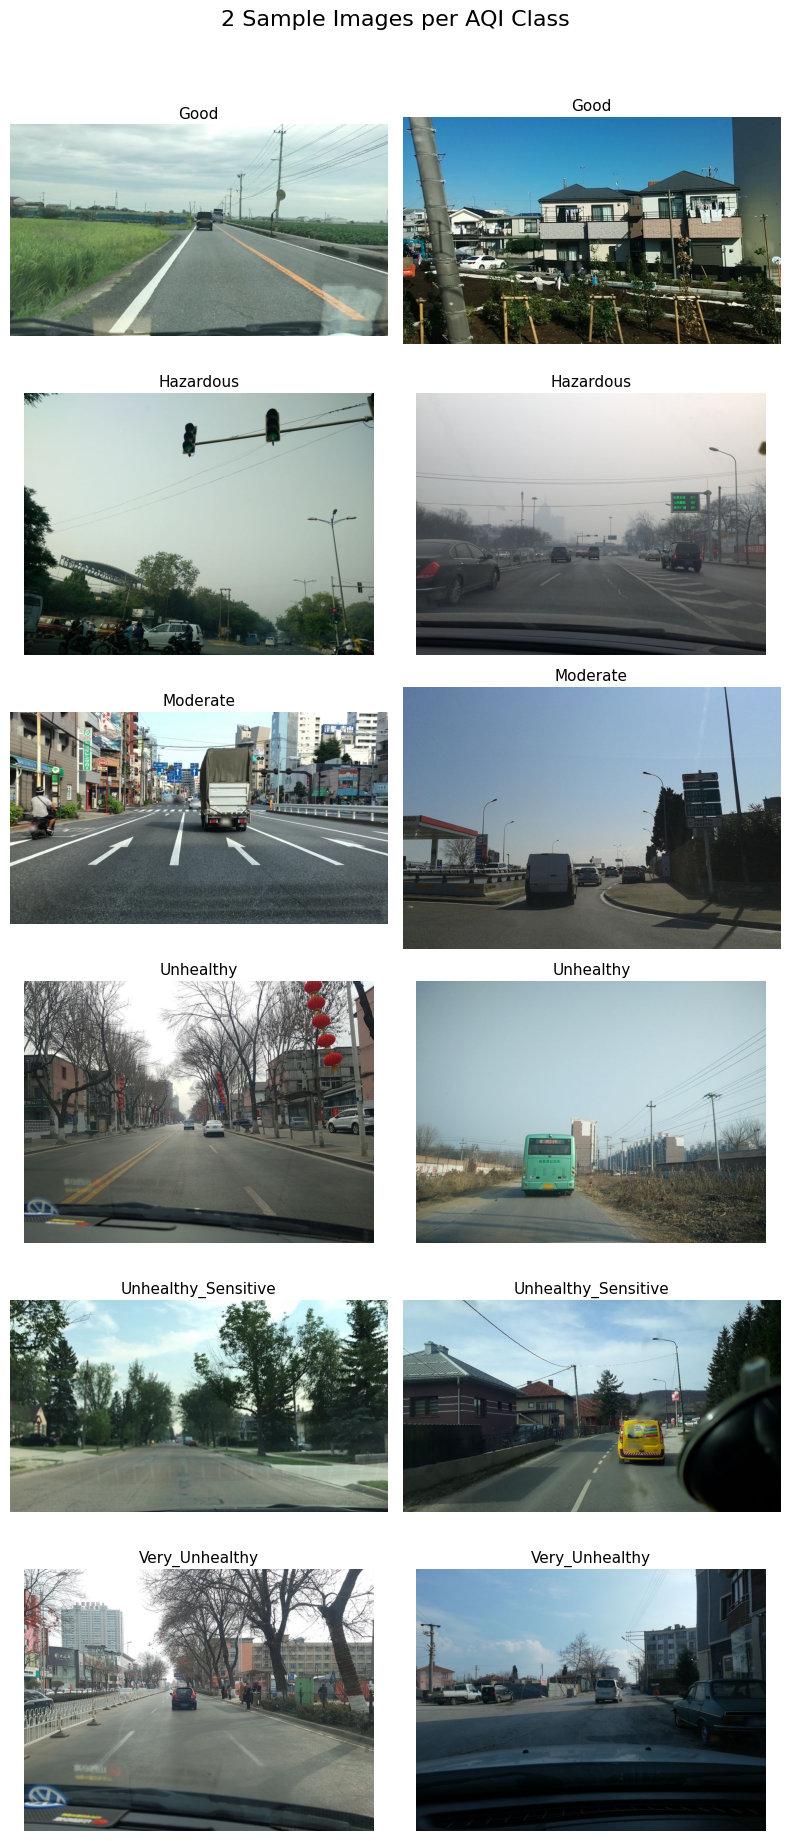

In [13]:
from PIL import Image

classes = sorted(df["label"].unique())

N_PER_CLASS = 2

plt.figure(figsize=(N_PER_CLASS * 4, len(classes) * 3))

for i, lbl in enumerate(classes):
    subset = df[df["label"] == lbl]["path"].tolist()
    sample_paths = random.sample(subset, min(N_PER_CLASS, len(subset)))
    
    for j, path in enumerate(sample_paths):
        idx = i * N_PER_CLASS + j + 1
        plt.subplot(len(classes), N_PER_CLASS, idx)
        
        img = Image.open(path)
        plt.imshow(img)
        plt.axis("off")
        
        plt.title(lbl, fontsize=11, pad=4)

plt.suptitle("2 Sample Images per AQI Class", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

This function scans a dataset split directory (train/val/test), collects all image file paths along with their class labels, and returns them as a DataFrame. It also supports optional class filtering, allowing you to load only selected classes when needed.

In [14]:
def load_split(split_dir, selected_classes=None):
    file_paths, labels = [], []
    for class_name in os.listdir(split_dir):
        if selected_classes and class_name not in selected_classes:
            continue  
        class_dir = os.path.join(split_dir, class_name)
        if os.path.isdir(class_dir):
            for image_name in os.listdir(class_dir):
                file_paths.append(os.path.join(class_dir, image_name))
                labels.append(class_name)
    return pd.DataFrame({"file_path": file_paths, "label": labels})


This block defines the PM2.5 air-quality classes, loads all images belonging to these categories, and prints both the total image count and per-class distribution. It helps verify that the dataset has been correctly loaded and filtered.

In [15]:
PM25_CLASSES = [
    "Good",
    "Moderate",
    "Unhealthy_Sensitive",
    "Unhealthy",
    "Very_Unhealthy",
    "Hazardous"
]

data = load_split(data_dir, selected_classes=PM25_CLASSES)

print("Total images:", len(data))
print(data["label"].value_counts())


Total images: 11103
label
Good                   2408
Moderate               2407
Unhealthy              2407
Unhealthy_Sensitive    2393
Very_Unhealthy         1007
Hazardous               481
Name: count, dtype: int64


This block splits the dataset into train, validation, and test sets using stratified sampling to preserve class balance. First, 70% is allocated for training, and the remaining 30% is split evenly into validation and test sets. The sizes of each split are printed for verification.

In [16]:
from sklearn.model_selection import train_test_split

train_dataframe, temp_dataframe = train_test_split(
    data,
    test_size=0.20,
    stratify=data["label"],
    random_state=42
)

validation_dataframe, test_dataframe = train_test_split(
    temp_dataframe,
    test_size=0.50,
    stratify=temp_dataframe["label"],
    random_state=42
)

print(len(train_dataframe))
print(len(validation_dataframe))
print(len(test_dataframe))


8882
1110
1111


This block defines a flexible dataset class used for both self-supervised BYOL training and supervised downstream tasks. It loads image file paths, applies the required transformations, and conditionally encodes labels when operating in labeled mode. During BYOL pretext training, the class returns two augmented views of the same image, while in supervised mode it returns a single transformed image along with its numeric label. This ensures a unified, consistent data-loading pipeline for all stages of the workflow.

In [17]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform, is_lb=False):
        self.file_paths = dataframe["file_path"].values
        self.transform = transform
        self.is_lb = is_lb

        if self.is_lb:
            self.labels = dataframe["label"].values
            self.class_to_idx = {cls: idx for idx, cls in enumerate(sorted(set(self.labels)))}
            self.labels = np.array([self.class_to_idx[lbl] for lbl in self.labels])

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index):
        image_path = self.file_paths[index]
        image = PIL.Image.open(image_path).convert("RGB")

        if self.is_lb:
            label = self.labels[index]
            img_out = self.transform(image)
            return img_out, label

        else:
            output = self.transform(image)

            # MAETransform returns a tuple (view,)
            if isinstance(output, tuple):
                return output[0]   # extract the single view

            # Fallback for torchvision transforms
            return output


This block creates the two augmented image views required for BYOL pretext training. Each view applies a different set of transformations (crop, color jitter, blur, normalization) to help the model learn stable and invariant feature representations.

In [18]:
mae_transform = MAETransform()

def target_transform(t):
    return 0     




This block prepares the self-supervised training data by applying the BYOL dual-view transforms and wrapping the dataset in a DataLoader. It enables efficient batch loading, shuffling, and parallel processing for the pretext training stage.

In [19]:
training_dataset = ImageDataset(
    train_dataframe,
    transform=mae_transform,
    is_lb=False
)

dataloader = DataLoader(
    training_dataset,
    batch_size=training_batch,
    shuffle=True,
    drop_last=True,
    num_workers=2
)


This block defines a helper function to display paired BYOL views for randomly selected images. It shows how each image is transformed into two different augmented versions, helping verify that the dual-view augmentation pipeline is working correctly.

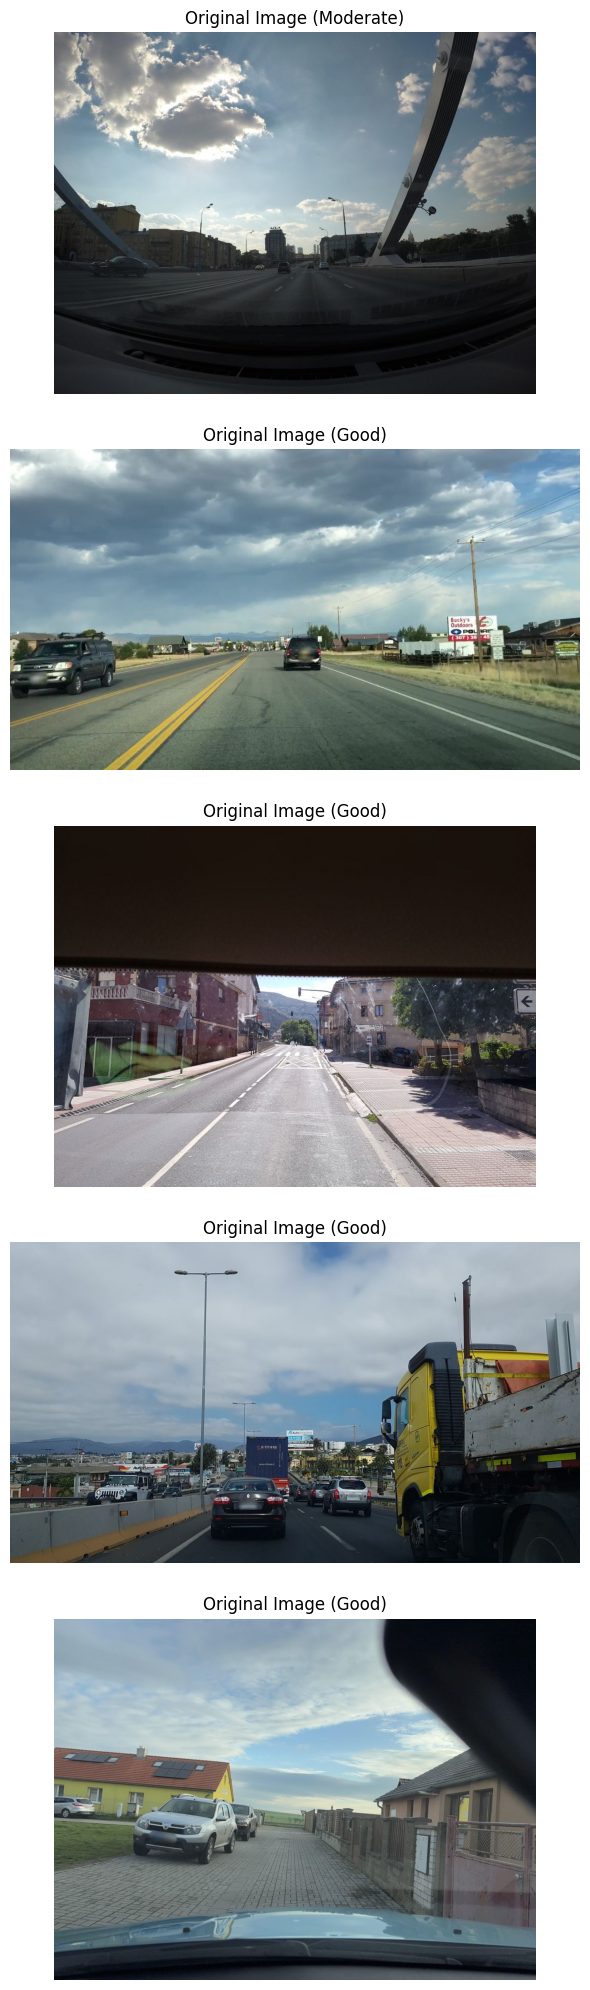

In [20]:
def visualize_original_images(df, num_imgs=5):
    fig, axes = plt.subplots(num_imgs, 1, figsize=(6, 4*num_imgs))

    random_indices = random.sample(range(len(df)), num_imgs)

    for i, idx in enumerate(random_indices):
        img_path = df.iloc[idx]["file_path"]

        img = PIL.Image.open(img_path).convert("RGB")
        axes[i].imshow(img)
        axes[i].set_title(f"Original Image ({df.iloc[idx]['label']})")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

visualize_original_images(train_dataframe, num_imgs=5)



This block defines the full BYOL architecture using a ResNet-50 encoder. It builds the online network with projection and prediction heads, creates a momentum (target) network via a frozen copy of the backbone and projection head, and sets up both forward passes required for BYOL training. The model is then moved to the selected device for pretext learning.

In [21]:
class MAE(nn.Module):
    def __init__(self, vit):
        super().__init__()

        decoder_dim = 512
        self.mask_ratio = 0.75
        self.patch_size = vit.patch_embed.patch_size[0]

        self.backbone = MaskedVisionTransformerTIMM(vit=vit)
        self.sequence_length = self.backbone.sequence_length
        self.decoder = MAEDecoderTIMM(
            num_patches=vit.patch_embed.num_patches,
            patch_size=self.patch_size,
            embed_dim=vit.embed_dim,
            decoder_embed_dim=decoder_dim,
            decoder_depth=1,
            decoder_num_heads=16,
            mlp_ratio=4.0,
            proj_drop_rate=0.0,
            attn_drop_rate=0.0,
        )

    def forward_encoder(self, images, idx_keep=None):
        return self.backbone.encode(images=images, idx_keep=idx_keep)

    def forward_decoder(self, x_encoded, idx_keep, idx_mask):
        batch_size = x_encoded.shape[0]
        x_decode = self.decoder.embed(x_encoded)
        x_masked = utils.repeat_token(
            self.decoder.mask_token, (batch_size, self.sequence_length)
        )
        x_masked = utils.set_at_index(x_masked, idx_keep, x_decode.type_as(x_masked))
        x_decoded = self.decoder.decode(x_masked)
        x_pred = utils.get_at_index(x_decoded, idx_mask)
        x_pred = self.decoder.predict(x_pred)
        return x_pred

    def forward(self, images):
        batch_size = images.shape[0]
        idx_keep, idx_mask = utils.random_token_mask(
            size=(batch_size, self.sequence_length),
            mask_ratio=self.mask_ratio,
            device=images.device,
        )
        x_encoded = self.forward_encoder(images=images, idx_keep=idx_keep)
        x_pred = self.forward_decoder(
            x_encoded=x_encoded, idx_keep=idx_keep, idx_mask=idx_mask
        )
        patches = utils.patchify(images, self.patch_size)
        target = utils.get_at_index(patches, idx_mask - 1)
        return x_pred, target


vit = vit_base_patch32_224()
model = MAE(vit).to(device)


This block installs THOP and uses it to measure the computational cost of the ResNet-50 backbone at 224×224 resolution. It calculates MACs, derives FLOPs, and reports total parameters—providing a clear summary of the model’s efficiency and resource requirements.

In [22]:
!pip install thop >/dev/null
from thop import profile, clever_format

dummy_input = torch.randn(1, 3, 224, 224).to(device)

# MAE encoder FLOPs
macs, params = profile(model.backbone, inputs=(dummy_input,), verbose=False)
macs, params = clever_format([macs, params], "%.3f")

float_macs = float(macs[:-1])
gflops = float_macs * 2

print("\n[Complexity @224x224]")
print("MACs:", macs)
print("GFLOPs:", gflops)
print("Params:", params)




[Complexity @224x224]
MACs: 4.362G
GFLOPs: 8.724
Params: 87.378M


This block sets up the Negative Cosine Similarity loss for BYOL and configures the LARS optimizer with the chosen learning rate, weight decay, and momentum for stable SSL training.

In [23]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1.5e-4)



This block handles the complete BYOL training process—loading previous checkpoints and loss logs, initializing AMP mixed-precision training, restoring optimizer/scaler states, and setting up safe resume logic. It then runs the full epoch loop with momentum updates, loss tracking, periodic checkpoint saving, and prints total training time. Designed to continue training seamlessly even after Kaggle interruptions.

In [24]:
from torch import amp
import shutil
import csv
import pandas as pd
import time
import os
import torch

loss_file = "/kaggle/working/mae_loss.csv"

uploaded_loss_path = "/kaggle/input/loss-curv/loss.csv"
uploaded_resume_path = "/kaggle/input/pretext-resume/mae_checkpoint.pth"
working_checkpoint_path = "/kaggle/working/mae_checkpoint.pth"


# ---------- LOSS CSV LOADING ----------
if os.path.exists(uploaded_loss_path):
    print("Using uploaded previous loss.csv")
    shutil.copy(uploaded_loss_path, loss_file)
else:
    print("No uploaded loss.csv found")

# AMP Scaler
scaler = amp.GradScaler("cuda")
loss_history = []

# create loss.csv if not exists
if not os.path.exists(loss_file):
    print("Creating new loss.csv")
    with open(loss_file, "w", newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "loss"])


# ---------- CLEAN STATE_DICT FOR FVCORE ----------
def load_clean_state_dict(model, state_dict):
    clean_sd = {}
    for k, v in state_dict.items():
        if "total_ops" in k or "total_params" in k:
            continue
        clean_sd[k] = v
    return clean_sd


# ---------- RESUME LOGIC ----------
start_epoch = 1

if os.path.exists(uploaded_resume_path):
    print("Loaded checkpoint from uploaded dataset.")
    ckpt = torch.load(uploaded_resume_path, map_location=device)

    model.load_state_dict(load_clean_state_dict(model, ckpt['model_state_dict']), strict=False)
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])

    if "scaler_state_dict" in ckpt:
        scaler.load_state_dict(ckpt["scaler_state_dict"])

    start_epoch = ckpt["epoch"] + 1
    print(f"Resume training from epoch {start_epoch}")

elif os.path.exists(working_checkpoint_path):
    print("Found working checkpoint — resuming...")
    ckpt = torch.load(working_checkpoint_path, map_location=device)

    model.load_state_dict(load_clean_state_dict(model, ckpt['model_state_dict']), strict=False)
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])

    if "scaler_state_dict" in ckpt:
        scaler.load_state_dict(ckpt["scaler_state_dict"])

    start_epoch = ckpt["epoch"] + 1
    print(f"Resume training from epoch {start_epoch}")

else:
    print("No checkpoint found → Starting from epoch 1")
    start_epoch = 1


# ---------- SHOW PREVIOUS LOSS ----------
print("\n=== PREVIOUS EPOCHS (FROM loss.csv) ===")
print(pd.read_csv(loss_file))


# ---------- TRAINING LOOP ----------
print("\nStarting Training\n")
total_start_time = time.time()

for epoch in range(start_epoch, total_epochs + 1):
    start_time = time.time()
    total_loss = 0

    for batch_data in dataloader:
        images = batch_data[0].to(device)

        optimizer.zero_grad()

        # AMP
        with amp.autocast("cuda"):
            preds, targets = model(images)
            loss = criterion(preds, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    loss_history.append(avg_loss)

    # epoch timing
    epoch_time = time.time() - start_time
    m = int(epoch_time // 60)
    s = int(epoch_time % 60)

    print(f"epoch: {epoch}, loss: {avg_loss:.5f}, time: {m}m {s}s")

    # append to loss.csv
    with open(loss_file, "a", newline='') as f:
        csv.writer(f).writerow([epoch, avg_loss])

    # save MAE checkpoint
    torch.save({
        "epoch": epoch,
        "loss": avg_loss,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scaler_state_dict": scaler.state_dict()
    }, working_checkpoint_path)


# ---------- TRAINING COMPLETE ----------
total_end_time = time.time()
duration = total_end_time - total_start_time
hours = int(duration // 3600)
minutes = int((duration % 3600) // 60)
seconds = int(duration % 60)

print("\nTraining completed!")
print(f"Total training time: {hours}h {minutes}m {seconds}s")

No uploaded loss.csv found
Creating new loss.csv
No checkpoint found → Starting from epoch 1

=== PREVIOUS EPOCHS (FROM loss.csv) ===
Empty DataFrame
Columns: [epoch, loss]
Index: []

Starting Training

epoch: 1, loss: 0.79782, time: 1m 5s
epoch: 2, loss: 0.53691, time: 1m 6s
epoch: 3, loss: 0.48173, time: 1m 5s
epoch: 4, loss: 0.45663, time: 1m 6s
epoch: 5, loss: 0.44837, time: 1m 5s
epoch: 6, loss: 0.43914, time: 1m 6s
epoch: 7, loss: 0.42826, time: 1m 6s
epoch: 8, loss: 0.42219, time: 1m 6s
epoch: 9, loss: 0.41513, time: 1m 6s
epoch: 10, loss: 0.41222, time: 1m 6s
epoch: 11, loss: 0.40714, time: 1m 6s
epoch: 12, loss: 0.40425, time: 1m 5s
epoch: 13, loss: 0.40465, time: 1m 6s
epoch: 14, loss: 0.40049, time: 1m 5s
epoch: 15, loss: 0.39928, time: 1m 6s
epoch: 16, loss: 0.39673, time: 1m 7s
epoch: 17, loss: 0.39285, time: 1m 6s
epoch: 18, loss: 0.39328, time: 1m 6s
epoch: 19, loss: 0.39216, time: 1m 5s
epoch: 20, loss: 0.38822, time: 1m 6s
epoch: 21, loss: 0.38958, time: 1m 7s
epoch: 2

This block reads the saved loss.csv file and visualizes how the BYOL training loss changes across epochs. It helps verify training stability, detect convergence trends, and ensure the model is learning as expected.

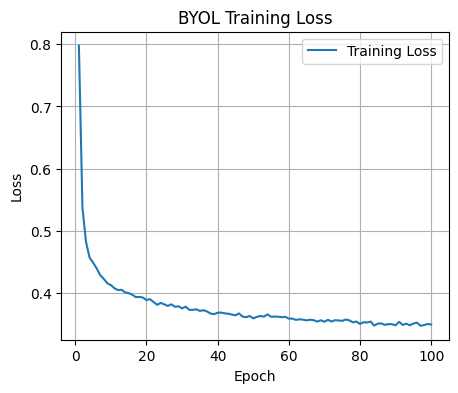

In [25]:
loss_df = pd.read_csv(loss_file)

plt.figure(figsize=(5,4))
plt.plot(loss_df['epoch'], loss_df['loss'], label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("BYOL Training Loss")
plt.grid(True)
plt.legend()
plt.show()


This block switches the model to evaluation mode, prepares a normalized transform, and builds a labeled dataset for embedding extraction. It then passes all images through the BYOL backbone to collect feature vectors and their labels, finally saving them as a .npz file for use in linear probing, shallow classifiers, and other downstream evaluations.

In [26]:
model.eval()

embedding_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

embedding_dataset = ImageDataset(train_dataframe, transform=embedding_transform, is_lb=True)
embedding_loader = DataLoader(embedding_dataset, batch_size=training_batch, shuffle=False)

def extract_embeddings(model, dataloader, device):
    embeddings = []
    labels_list = []

    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)

            # ----- build idx_keep to keep ALL tokens -----
            B = images.size(0)
            seq_len = model.sequence_length
            idx_keep = torch.arange(seq_len).unsqueeze(0).repeat(B, 1).to(device)

            # ----- forward encoder WITHOUT masking -----
            feats = model.forward_encoder(images=images, idx_keep=idx_keep)

            # feats shape: [B, seq_len, embed_dim]
            # Use CLS token (index 0)
            cls_feats = feats[:, 0, :]

            embeddings.append(cls_feats.cpu())
            labels_list.append(labels.cpu())

    embeddings = torch.cat(embeddings, dim=0).numpy()
    labels = torch.cat(labels_list, dim=0).numpy()
    return embeddings, labels


embeddings, labels = extract_embeddings(model, embedding_loader, device)
np.savez(embedding_path, embeddings=embeddings, labels=labels)


This block applies t-SNE to reduce the high-dimensional BYOL embeddings to 2D and visualizes them with a scatter plot. It helps assess how well the learned features separate different PM2.5 classes in the embedding space.

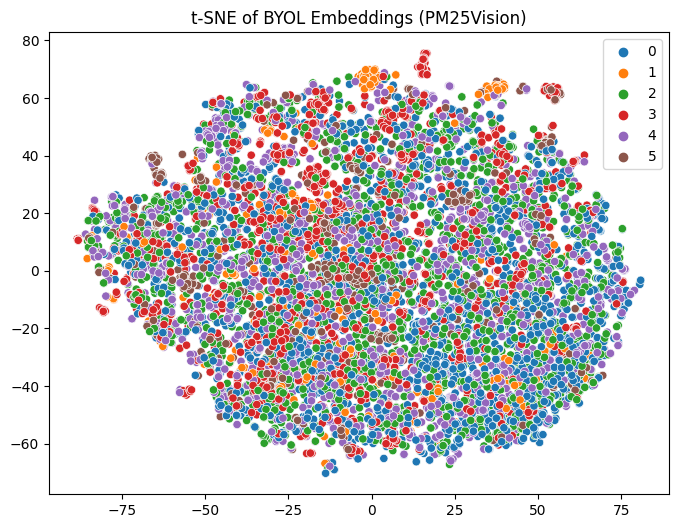

In [27]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(8,6))
sns.scatterplot(x=embeddings_2d[:,0], y=embeddings_2d[:,1], hue=labels, palette="tab10")
plt.title("t-SNE of BYOL Embeddings (PM25Vision)")
plt.show()


This block performs KMeans clustering on the BYOL embeddings, computes the Silhouette Score to measure cluster quality, and visualizes the resulting clusters on the 2D t-SNE plot. It helps assess how well the learned features naturally group PM2.5 categories.

Silhouette Score: 0.092


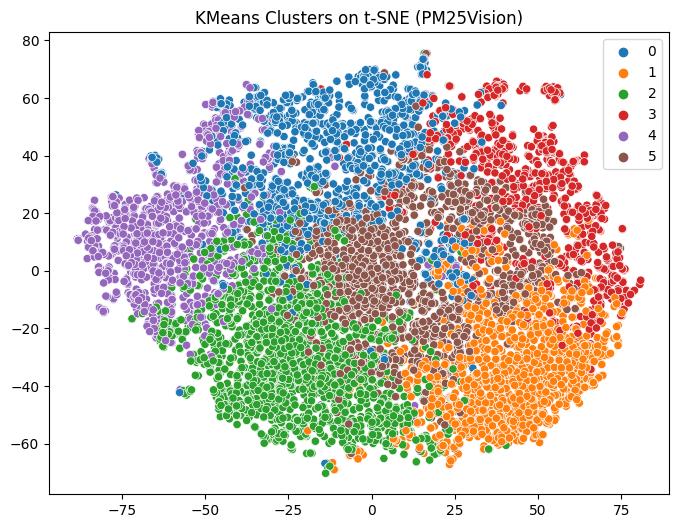

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=6, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

silhouette_avg = silhouette_score(embeddings, cluster_labels)
print(f"Silhouette Score: {silhouette_avg:.3f}")

plt.figure(figsize=(8,6))
sns.scatterplot(x=embeddings_2d[:,0], y=embeddings_2d[:,1], hue=cluster_labels, palette="tab10")
plt.title("KMeans Clusters on t-SNE (PM25Vision)")
plt.show()
